In [86]:
import time
import random
import typing as tp
import os
from functools import partial, wraps

import requests
import asyncio

import cv2
import dlib
import numpy as np
import pandas as pd
from lxml import html
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, classification_report, precision_score, recall_score, accuracy_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer, PolynomialFeatures, FunctionTransformer, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, RFE
from sklearn.decomposition import PCA
sns.set()

In [115]:
desktop_agents = ['Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36',
                 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36',
                 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36',
                 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_1) AppleWebKit/602.2.14 (KHTML, like Gecko) Version/10.0.1 Safari/602.2.14',
                 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36',
                 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.98 Safari/537.36',
                 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.98 Safari/537.36',
                 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36',
                 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36',
                 'Mozilla/5.0 (Windows NT 10.0; WOW64; rv:50.0) Gecko/20100101 Firefox/50.0']

with open('http_proxies.txt', 'r') as f:
    list_proxy = list(map(lambda x: x.strip(), f.readlines()))

def random_proxy() -> tp.Dict[str, str]:
    return {'http': np.random.choice(list_proxy)}

def random_headers() -> tp.Dict[str, str]:
    return {'User-Agent': np.random.choice(desktop_agents),'Accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8'}
 
def get_links(name: str, pages: tp.Optional[tp.List[int]] = None) -> tp.List[str]:
    name_as_list = name.lower().split(' ')
    phrase = '%20'.join(name_as_list)
    search_crit = '-'.join(name_as_list)
    time.sleep(random.uniform(1, 2))
    req_p = pages if pages else [1]
    resp = []
    for pg in req_p:
        header = random_headers()
        proxy = random_proxy()
        response = requests.get(f'https://www.gettyimages.com/photos/{search_crit}?family=editorial&page={pg}&phrase={phrase}&sort=mostpopular',
                               headers=header,
                               proxies=proxy)
        tree = html.fromstring(response.content)
        resp.append(tree.xpath('//div[@class="search-content__gallery-results"]//@src'))
        time.sleep(random.uniform(1.5, 2.5))
    return list(sum(resp, []))

def img_from_link(link: str) -> np.ndarray:
    time.sleep(random.uniform(0.5, 2.5))
    resp = requests.get(link).content
    img = cv2.cvtColor(cv2.imdecode(np.asarray(bytearray(resp), dtype='uint8'), 
                     cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY)
    return img

def haar_cascade(img: np.ndarray, corrupt: bool = False, final_size: tp.Tuple[int] = (128,128)) ->tp.Union[None, np.ndarray]:
    img_c = img.copy()
    assert len(img.shape)==2, 'img must be grayscale'
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    try:
        list_faces = face_cascade.detectMultiScale(img_c, 1.7, 5)
        faces = []
        for f in list_faces:
            print(f)
            x,y,w,h = f
            eps = int(max(w, h)*0.1)
            if corrupt:
                img_c[y+eps:y+h-eps,x+eps:x+w+eps] = 0
            faces.append(cv2.resize(img_c[y:y+h, x: x+w], final_size))
        return faces
    except:
        return None

def hog_cascade(img: np.ndarray, corrupt: bool = False, final_size: tp.Tuple[int] = (128,128)) ->tp.Union[None, np.ndarray]:
    img_c = img.copy()
    assert len(img.shape)==2, 'img must be grayscale'
    face_cascade = dlib.get_frontal_face_detector()
    try:
        list_faces = face_cascade(img_c, 1)
        faces = []
        for f in list_faces:
            x,y,w,h = f.left(), f.top(), f.right(), f.bottom()
            w, h = w-x, h-y
            eps = int(max(w, h)*0.1)
            if corrupt:
                img_c[y+eps:y+h-eps,x+eps:x+w+eps] = 0
            faces.append(cv2.resize(img_c[y:y+h, x: x+w], final_size))
        return faces
    except:
        cv2.resize(img_c[y:y+h, x: x+w], final_size)

In [88]:
os.mkdir('test 1')
os.mkdir('train 1')

FileExistsError: [WinError 183] Невозможно создать файл, так как он уже существует: 'test 1'

In [116]:
celebrities = ['barack obama portrait', 'samuel l jackson', 'bill clinton', 'donald trump']
train_data = dict(path=[], label=[])
test_data = dict(path=[], label=[])

In [118]:
for idx_celeb, celeb in enumerate(celebrities):
    pages = range(1,6) if 'obama' in celeb.split(' ') else None
    links = get_links(celeb, pages)
    folders = np.random.default_rng().choice(['train 1', 'test 1'], p=[0.7, 0.3], size=len(links))
    for idx, (l, f) in enumerate(zip(links, folders)):
        img = img_from_link(l)
        path = f'{f}\\img_{idx_celeb}_{idx}'
        if f=='test 1':
            corrupt = np.random.default_rng().choice([True, False], p=[0.05, 0.95])
            img = hog_cascade(img, corrupt=corrupt)
            if img is not None:
                for n, i in enumerate(img):
                    test_data['path'].append(path+f'_{n}.png')
                    test_data['label'].append(int('obama' in celeb.split(' ')))
                    cv2.imwrite(path+f'_{n}.png', i)
        else:
            img = hog_cascade(img)
            if img is not None:
                for n, i in enumerate(img):
                    train_data['path'].append(path+f'_{n}.png')
                    train_data['label'].append(int('obama' in celeb.split(' ')))
                    cv2.imwrite(path+f'_{n}.png', i)
        
        
pd.DataFrame(train_data).to_csv('train_hog.csv', index=False)
pd.DataFrame(test_data).to_csv('test_hog.csv', index=False)
    

ConnectionError: HTTPSConnectionPool(host='media.gettyimages.com', port=443): Max retries exceeded with url: /photos/the-unveiling-of-madame-tussauds-new-york-wax-figure-of-barack-obama-picture-id84300756?k=6&m=84300756&s=612x612&w=0&h=Q6DojUJaIUwqMpfBkYCdUty-k_6DPyfIUdJ1yI_qbp0= (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000001860BCF5FD0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [34]:
def timeit(filename: tp.Union[str, None]=None):
    def inner(method: tp.Callable[[tp.Any],tp.Any]):
        @wraps(method)
        def timed(*args, **kwargs):
            ts = time.time()
            result = method(*args, **kwargs)
            te = time.time()
            print('%r execution completed in %d m %2.2f s' % \
                      (method.__name__, (te - ts)//60, ((te-ts)-60*((te - ts)//60)) ))
            if (filename is not None) and (type(result)==dict):
                result.update({'time':'{} m {:2.2f} s'.format((te - ts)//60, ((te-ts)-60*((te - ts)//60)))})
                with open(filename, 'a+', newline='') as f:
                    pd.DataFrame(result, index=['method']).to_csv(f, header=f.tell()==0)
            return result
        return timed
    return inner

In [60]:
@timeit(filename='log_results.csv')
def get_best_estimator(estimator: Pipeline, dataset: tp.Dict[str, np.ndarray], params_search: tp.Dict[str, tp.List[float]], 
                      return_scores: bool=False, **kwargs) -> Pipeline:
    """
    Simple yet helpful function to get best estimator based on f1 score
    """
    name = str(estimator[-1]).split('(')[0]
    print('calulating %r' %name)
    grid = GridSearchCV(estimator=estimator,
                        param_grid=params_search, 
                        cv=None, 
                        n_jobs=-1,
                       scoring=make_scorer(partial(f1_score, average='weighted'))
                       )
    grid.fit(dataset['X_train'], dataset['y_train'])
    if return_scores:
        results = dict(method=[],
                      feature_selector=[],
                      train_test_fraction=[],
                      precision=[],
                      recall=[],
                      f1_score=[],
                      accuracy=[])
        results['method'] = name
        results['precision'] = precision_score(dataset['y_test'], 
                                            grid.best_estimator_.predict(dataset['X_test']), average='weighted')
        results['recall'] = recall_score(dataset['y_test'], 
                                            grid.best_estimator_.predict(dataset['X_test']), average='weighted')
        results['f1_score'] = f1_score(dataset['y_test'], 
                                            grid.best_estimator_.predict(dataset['X_test']), average='weighted')
        results['accuracy'] = accuracy_score(dataset['y_test'], 
                                            grid.best_estimator_.predict(dataset['X_test']))
        return results
    return grid.best_estimator_ 

@timeit()
def show_heatmap(data: tp.Union[np.ndarray, pd.DataFrame], title: str, figsize: tuple=(10,10)) -> None:
    plt.figure(figsize=figsize)
    plt.title(title,)
    hm = sns.heatmap(data, annot=True)
    plt.show()

In [36]:
train_ds = pd.read_csv('train.csv')
test_ds = pd.read_csv('test.csv')

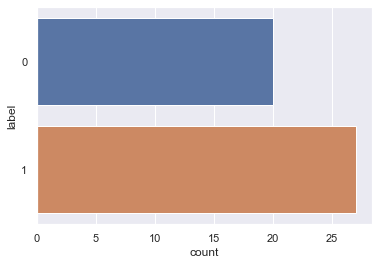

In [37]:
sns.countplot(y = test_ds.label)
plt.show()

In [49]:
images_train, images_test = [], []
for tr in train_ds['path']:
    images_train.append(cv2.cvtColor(cv2.imread(tr, cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY).reshape(-1,))
for tr in test_ds['path']:
    images_test.append(cv2.cvtColor(cv2.imread(tr, cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY).reshape(-1,))
images_train = np.asarray(images_train)
images_test = np.asarray(images_test)

In [54]:
svm_nonlinear_pipeline = make_pipeline(MinMaxScaler(),
                                      PCA(n_components=0.8),
                                      SVC())

In [57]:
svm_nonlinear = get_best_estimator(svm_nonlinear_pipeline, 
                               dataset={'X_train':images_train , 'y_train': train_ds['label'].values.ravel(),
                                       'X_test':images_test, 'y_test': test_ds['label'].values.ravel()},
                              params_search={'svc__C':[1e3, 5e3, 1e4, 5e4, 1e5],
                                     'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
                                     'svc__kernel': ['rbf']})

calulating 'SVC'
'get_best_estimator' execution completed in 0 m 48.65 s


In [58]:
print(classification_report(test_ds['label'].values.ravel(), svm_nonlinear.predict(images_test)))

              precision    recall  f1-score   support

           0       0.57      0.60      0.59        20
           1       0.69      0.67      0.68        27

    accuracy                           0.64        47
   macro avg       0.63      0.63      0.63        47
weighted avg       0.64      0.64      0.64        47



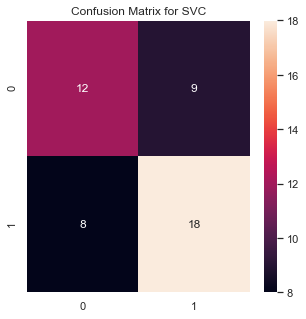

'show_heatmap' execution completed in 0 m 0.15 s


In [61]:
show_heatmap(confusion_matrix(svm_nonlinear.predict(images_test), test_ds['label'].values.ravel()),
                 f'Confusion Matrix for SVC', figsize=(5,5))